In [1]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import torch
import os

import xgboost as xgb
from sklearn.model_selection import RepeatedKFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from matplotlib.ticker import StrMethodFormatter

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/export.csv')
df.head()

,drug_id,drug_name,synonyms,pathway_name,targets,pubchem
0,1259,Talazoparib,"BMN-673, BMN 973",Genome integrity,"PARP1, PARP2",44819241
1,1372,Trametinib,"GSK1120212, Mekinist",ERK MAPK signaling,"MEK1, MEK2",11707110
2,1559,Luminespib,"AUY922, VER-52296,NVP-AUY922, AUY",Protein stability and degradation,HSP90,10096043
3,1615,CZC24832,GTPL6653,PI3K/MTOR signaling,PI3Kgamma,42623951
4,1620,PFI3,"PFI-3, PFI 3, AOB2221",Chromatin other,"Polybromo 1, SMARCA4, SMARCA2",78243717


In [3]:
def readGeneticData(dataPath):
    df_Gen = pd.read_csv(dataPath)
    df_Gen['IS Mutated']=df_Gen['IS Mutated'].fillna(99)
    df_Gen['Recurrent Gain Loss']=df_Gen['Recurrent Gain Loss'].fillna('nan')
    df_Gen['Recurrent Gain Loss']=df_Gen['Recurrent Gain Loss'].map({'gain': 1, 'loss':0, 'nan': 3})
    return df_Gen
df_Gen = readGeneticData('data\PANCANCER_Genetic_features_Mon Feb 19 14_07_49 2024.csv')
df_Gen.head()

,Cell Line Name,COSMIC ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Genetic Feature,IS Mutated,Recurrent Gain Loss,Genes in Segment
0,CAL-29,1290730,urogenital_system,bladder,BLCA,CDC27_mut,0,3,NaN
1,CAL-29,1290730,urogenital_system,bladder,BLCA,CDC73_mut,0,3,NaN
2,CAL-29,1290730,urogenital_system,bladder,BLCA,CDH1_mut,0,3,NaN
3,CAL-29,1290730,urogenital_system,bladder,BLCA,CDK12_mut,0,3,NaN
4,CAL-29,1290730,urogenital_system,bladder,BLCA,CDKN1A_mut,0,3,NaN


In [4]:
def readICData(dataPath):
    df_IC = pd.read_csv(dataPath)
    return df_IC

df_IC = readICData("data\PANCANCER_IC_Mon Feb 19 14_07_21 2024.csv")

In [5]:
unique_Genetic_Feature = df_Gen['Genetic Feature'].unique()
unique_Drugs = df_IC['Drug Name'].unique()

In [6]:
def generateGraphs(xgbm,path, graphType):
    sorted_idx = xgbm.get_booster().get_score(importance_type=graphType)#['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    sorted_idx = {k: v for k, v in sorted(sorted_idx.items(), key=lambda item: item[1])}
    pyplot.rcParams["figure.figsize"] = (20,20)
    pyplot.barh(np.array(list(sorted_idx.items()))[-20:,0], np.array(list(sorted_idx.items()))[-20:,1].astype(float))
    pyplot.xticks(rotation=45, ha='right')
    pyplot.savefig(path+'features_'+graphType+'.png')
    pyplot.close('all')
  

In [9]:
results_summary = []
for drug in unique_Drugs:
    df_select = df_IC.loc[df_IC['Drug Name'] == drug]
    df_select2 = df_select[['Drug Name', 'Cell Line Name', 'IC50']]#  'Tissue', 'Tissue Sub-type',
    df_select2.loc[:,unique_Genetic_Feature] = 99
    df_select2.loc[:,unique_Genetic_Feature+'_gain'] = 99
    for n in df_select2['Cell Line Name']: 
        df_select_Gen = df_Gen.loc[df_Gen['Cell Line Name'] == n][['Genetic Feature','IS Mutated','Recurrent Gain Loss']]
        df_select2.loc[df_select2['Cell Line Name'] == n,df_select_Gen['Genetic Feature']] = pd.pivot_table(df_select_Gen, values = 'IS Mutated', columns = 'Genetic Feature',sort=False).to_numpy()
        df_select2.loc[df_select2['Cell Line Name'] == n,df_select_Gen['Genetic Feature']+'_gain'] = pd.pivot_table(df_select_Gen, values = 'Recurrent Gain Loss', columns = 'Genetic Feature',sort=False).to_numpy()
    path = 'results_no_tissue/'+ drug.strip()+'/'
    os.mkdir(path)
    df_select2.to_csv(path+drug+'_raw'+'.csv')
    df_select2.dropna()
    df_select2.to_csv(path+drug+'_noNAN'+'.csv')
    model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    df_inputs = df_select2.drop(['Drug Name','Cell Line Name'], axis=1)
    # df_select2['Tissue'] = df_select2['Tissue'].astype('category').cat.codes
    # df_select2['Tissue Sub-type'] = df_select2['Tissue Sub-type'].astype('category').cat.codes
    df_input = df_select2.drop(['Drug Name','Cell Line Name','IC50'], axis=1)
    df_output = df_select2['IC50']
    X_train, X_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.2, random_state=42)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, df_input, df_output, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores = abs(scores)
    
    
    xgbm = model.fit(df_input,df_output)
    y_pred = model.predict(X_test)
    
    for n in ['weight', 'gain', 'cover', 'total_gain', 'total_cover']:
        generateGraphs(xgbm,path, n)
    
    # Mean Absolute Error (MAE)
    MAE = np.mean(abs(y_pred - y_test))
    # Median Absolute Error (MedAE)
    MEDAE = np.median(abs(y_pred - y_test))
    # Mean Squared Error (MSE)
    MSE = np.square(np.subtract(y_pred, y_test)).mean()
    # Root Mean Squarred Error (RMSE) 
    RMSE = np.sqrt(np.mean(np.square(y_pred - y_test)))
    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
    
    results_summary.append([drug,MAE,MEDAE,MSE,RMSE,MAPE,MDAPE])
    
    with open(path+'results.txt','w') as file:
        file.write('Ten-fold Error:\n')
        file.write('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) +'\n')
        file.write('Mean Absolute Error (MAE): ' + str(np.round(MAE, 4))+'\n')
        file.write('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 4))+'\n')
        file.write('Mean Squared Error (MSE): ' + str(np.round(MSE, 6))+'\n')
        file.write('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 4))+'\n')
        file.write('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 4)) + ' %'+'\n')
        file.write('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 4)) + ' %'+'\n')  
    
df_result = pd.DataFrame(results_summary,columns=['Drug','MAE','MEDAE','MSE','RMSE','MAPE','MDAPE'])
df_result.to_csv('results_no_tissue/results_summary.csv')
    

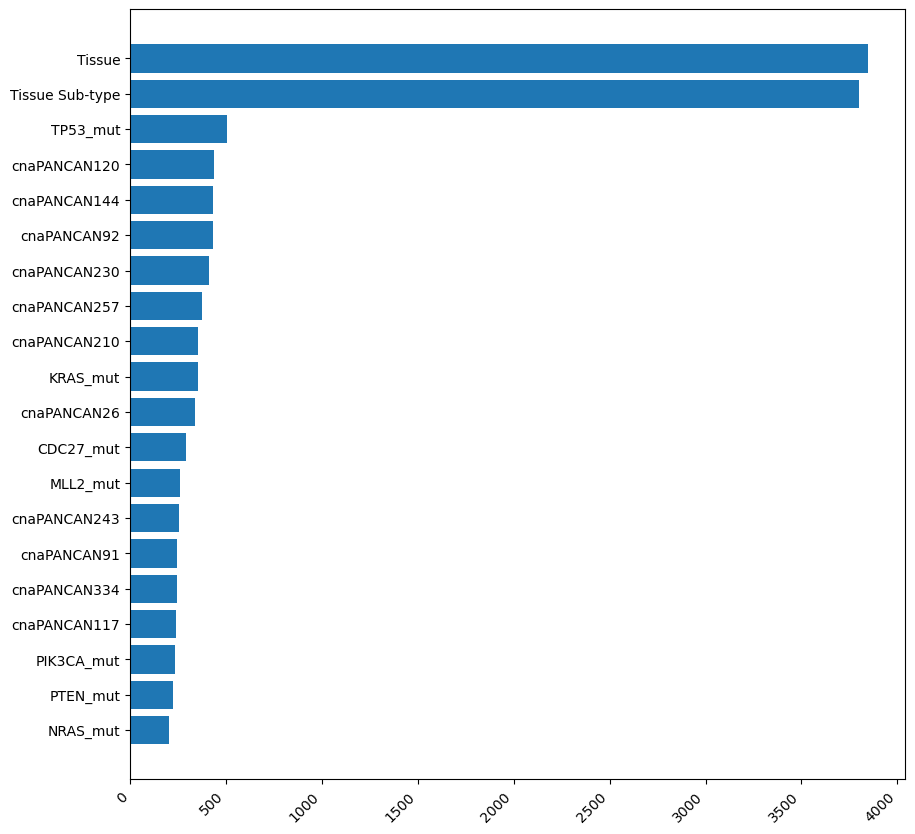

In [44]:
pyplot.close('all')
sorted_idx = xgbm.get_booster().get_score(importance_type='weight')#['weight', 'gain', 'cover', 'total_gain', 'total_cover']
sorted_idx = {k: v for k, v in sorted(sorted_idx.items(), key=lambda item: item[1])}
pyplot.rcParams["figure.figsize"] = (10,10)
pyplot.barh(np.array(list(sorted_idx.items()))[-20:,0], np.array(list(sorted_idx.items()))[-20:,1].astype(float))
pyplot.xticks(rotation=45, ha='right')
# pyplot.xlim([0, float(max(np.array(list(sorted_idx.items()))[-5:,1]))+0.5])
pyplot.show()

In [13]:
sorted_idx

{'ETV6.RUNX1_mut': 1.0,
 'IDH2_mut': 1.0,
 'MEN1_mut': 1.0,
 'MSR1_mut': 1.0,
 'NUP98_mut': 1.0,
 'PLXNA1_mut': 1.0,
 'RTN4_mut': 1.0,
 'SF3B1_mut': 1.0,
 'SMAD2_mut': 1.0,
 'SRGAP3_mut': 1.0,
 'UPF3B_mut': 1.0,
 'ZC3H11A_mut': 1.0,
 'ARHGEF6_mut': 1.0,
 'BAZ2B_mut': 1.0,
 'cnaPANCAN39': 1.0,
 'cnaPANCAN55': 1.0,
 'cnaPANCAN103': 1.0,
 'cnaPANCAN149': 1.0,
 'cnaPANCAN151': 1.0,
 'cnaPANCAN155': 1.0,
 'cnaPANCAN186': 1.0,
 'cnaPANCAN220': 1.0,
 'cnaPANCAN223': 1.0,
 'cnaPANCAN228': 1.0,
 'cnaPANCAN229': 1.0,
 'cnaPANCAN238': 1.0,
 'cnaPANCAN290': 1.0,
 'cnaPANCAN291': 1.0,
 'cnaPANCAN326': 1.0,
 'cnaPANCAN345': 1.0,
 'cnaPANCAN347': 1.0,
 'cnaPANCAN348': 1.0,
 'cnaPANCAN353': 1.0,
 'cnaPANCAN354': 1.0,
 'cnaPANCAN398': 1.0,
 'cnaPANCAN401': 1.0,
 'cnaPANCAN403': 1.0,
 'cnaPANCAN416': 1.0,
 'cnaPANCAN418': 1.0,
 'cnaPANCAN420': 1.0,
 'FAF1_mut': 2.0,
 'HLA.B_mut': 2.0,
 'PIK3CB_mut': 2.0,
 'RAD21_mut': 2.0,
 'SEC31A_mut': 2.0,
 'SETDB1_mut': 2.0,
 'TCF3.PBX1_mut': 2.0,
 'ZFP36L2_mut': 2.

Interpreting Scores

* High weight may indicate a feature is frequently used in splits but doesn't imply high predictive power.
* High gain suggests a feature has high predictive power when used in splits.
* Cover can help identify features that affect a large number of instances.